# Support Vector Machine

#### Build SVM model on suburban dataset. To understand the population in different areas and also the income levels of residents.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import pickle, joblib

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(r"D:\360digi\DS\Sharath\SVM\handson\Datasets-SVM\SalaryData_Train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30161 entries, 0 to 30160
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            30161 non-null  int64 
 1   workclass      30161 non-null  object
 2   education      30161 non-null  object
 3   educationno    30161 non-null  int64 
 4   maritalstatus  30161 non-null  object
 5   occupation     30161 non-null  object
 6   relationship   30161 non-null  object
 7   race           30161 non-null  object
 8   sex            30161 non-null  object
 9   capitalgain    30161 non-null  int64 
 10  capitalloss    30161 non-null  int64 
 11  hoursperweek   30161 non-null  int64 
 12  native         30161 non-null  object
 13  Salary         30161 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.2+ MB


In [4]:
df.describe()

,age,educationno,capitalgain,capitalloss,hoursperweek
count,30161.000000,30161.000000,30161.000000,30161.000000,30161.000000
mean,38.438115,10.121316,1092.044064,88.302311,40.931269
std,13.134830,2.550037,7406.466611,404.121321,11.980182
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [5]:
# Checking Null Values
df.isnull().sum() # no missing data

age              0
workclass        0
education        0
educationno      0
maritalstatus    0
occupation       0
relationship     0
race             0
sex              0
capitalgain      0
capitalloss      0
hoursperweek     0
native           0
Salary           0
dtype: int64

(array([22653.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  7508.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

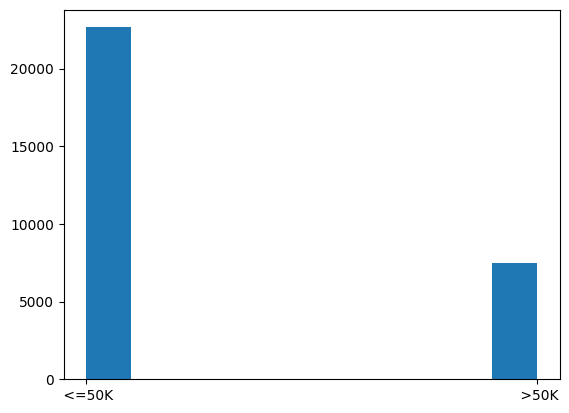

In [6]:
plt.hist(df.Salary)

# Data Preprocessing

In [7]:
X = df.iloc[:, :13]
Y = df.iloc[:, 13]

In [8]:
X

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30156,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
30157,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
30158,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
30159,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


In [9]:
Y

0         <=50K
1         <=50K
2         <=50K
3         <=50K
4         <=50K
          ...  
30156     <=50K
30157      >50K
30158     <=50K
30159     <=50K
30160      >50K
Name: Salary, Length: 30161, dtype: object

In [10]:
numeric_features = X.select_dtypes(exclude = ['object']).columns
numeric_features

Index(['age', 'educationno', 'capitalgain', 'capitalloss', 'hoursperweek'], dtype='object')

In [11]:
categorical_features = X.select_dtypes(include = ['object']).columns
categorical_features

Index(['workclass', 'education', 'maritalstatus', 'occupation', 'relationship',
       'race', 'sex', 'native'],
      dtype='object')

In [12]:
df['workclass'].unique() # 6

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' Self-emp-inc', ' Without-pay'], dtype=object)

In [13]:
df['education'].unique() #16

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' 7th-8th', ' Doctorate',
       ' Assoc-voc', ' Prof-school', ' 5th-6th', ' 10th', ' Preschool',
       ' 12th', ' 1st-4th'], dtype=object)

In [14]:
df['maritalstatus'].unique() #7

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [15]:
df['occupation'].unique() #14

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Transport-moving',
       ' Farming-fishing', ' Machine-op-inspct', ' Tech-support',
       ' Craft-repair', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [16]:
df['relationship'].unique() #6

array([' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried',
       ' Other-relative'], dtype=object)

In [17]:
df['race'].unique()  #5

array([' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',
       ' Other'], dtype=object)

In [18]:
df['sex'].unique() #2

array([' Male', ' Female'], dtype=object)

In [19]:
df['native'].unique() #40

array([' United-States', ' Cuba', ' Jamaica', ' India', ' Mexico',
       ' Puerto-Rico', ' Honduras', ' England', ' Canada', ' Germany',
       ' Iran', ' Philippines', ' Poland', ' Columbia', ' Cambodia',
       ' Thailand', ' Ecuador', ' Laos', ' Taiwan', ' Haiti', ' Portugal',
       ' Dominican-Republic', ' El-Salvador', ' France', ' Guatemala',
       ' Italy', ' China', ' South', ' Japan', ' Yugoslavia', ' Peru',
       ' Outlying-US(Guam-USVI-etc)', ' Scotland', ' Trinadad&Tobago',
       ' Greece', ' Nicaragua', ' Vietnam', ' Hong', ' Ireland',
       ' Hungary'], dtype=object)

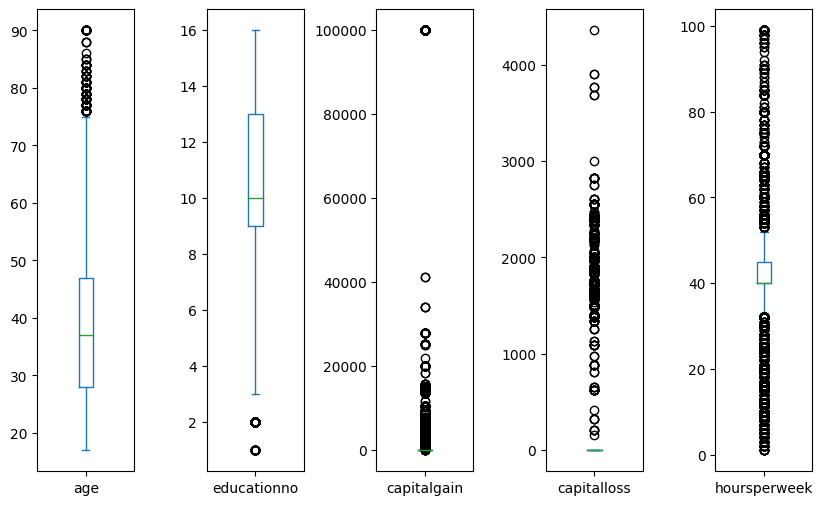

In [20]:
#Box plot visualization to view the outliers.
X.plot(kind = 'box', subplots = True, sharey = False, figsize = (10, 6))

plt.subplots_adjust(wspace = 0.75)
plt.show()

In [21]:
# Input columns ['capitalgain', 'capitalloss'] have low variation for method 'iqr'.

In [22]:
# Winsorization for "age" column
winsor = Winsorizer(capping_method = 'iqr', tail = 'both', fold = 1.5, variables = ['age'])

X['age'] = winsor.fit_transform(X[['age']])

In [23]:
# Winsorization for "educationno" column
winsor = Winsorizer(capping_method = 'iqr', tail = 'both', fold = 1.5, variables = ['educationno'])

X['educationno'] = winsor.fit_transform(X[['educationno']])

In [24]:
# Winsorization for "hoursperweek" column
winsor = Winsorizer(capping_method = 'iqr', tail = 'both', fold = 1.5, variables = ['hoursperweek'])

X['hoursperweek'] = winsor.fit_transform(X[['hoursperweek']])

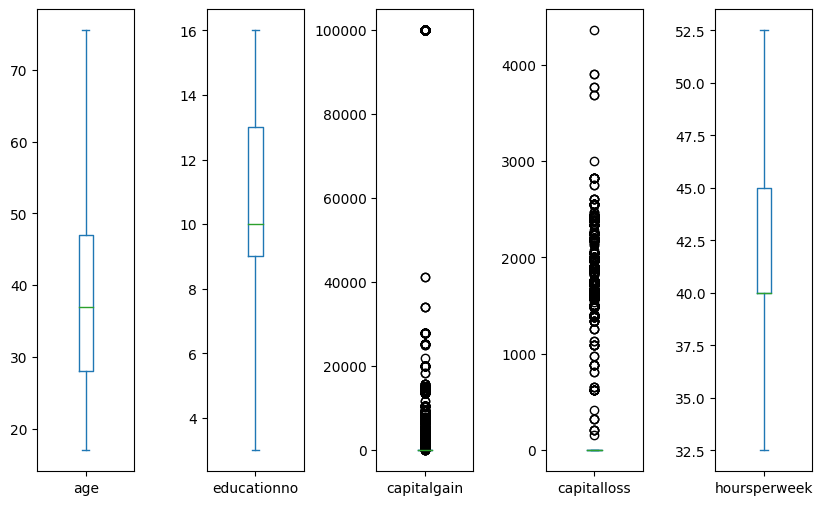

In [25]:
#Box plot visualization to view the outliers.
X.plot(kind = 'box', subplots = True, sharey = False, figsize = (10, 6))

plt.subplots_adjust(wspace = 0.75)
plt.show()

In [26]:
## Scaling with MinMaxScaler
scale_pipeline = Pipeline([('scale', MinMaxScaler())])

scale_columntransfer = ColumnTransformer([('scale', scale_pipeline, numeric_features)]) # Skips the transformations for remaining columns

scale = scale_columntransfer.fit(X)

In [27]:
scaled_data = pd.DataFrame(scale.transform(X), columns = numeric_features)
scaled_data.describe()

,age,educationno,capitalgain,capitalloss,hoursperweek
count,30161.000000,30161.000000,30161.000000,30161.000000,30161.000000
mean,0.365891,0.548408,0.010921,0.020271,0.445970
std,0.222678,0.194265,0.074065,0.092773,0.307302
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.188034,0.461538,0.000000,0.000000,0.375000
50%,0.341880,0.538462,0.000000,0.000000,0.375000
75%,0.512821,0.769231,0.000000,0.000000,0.625000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
# Save the data preprocessing pipeline
joblib.dump(scale, 'scale')

['scale']

In [29]:
## Encoding
# Categorical features
encoding_pipeline = Pipeline([('onehot', OneHotEncoder())])

preprocess_pipeline = ColumnTransformer([('categorical', encoding_pipeline, categorical_features)])

clean =  preprocess_pipeline.fit(X)

In [30]:
# Save the data preprocessing pipeline
joblib.dump(clean, 'encode')

['encode']

In [31]:
clean.transform(X)

<30161x97 sparse matrix of type '<class 'numpy.float64'>'
	with 241288 stored elements in Compressed Sparse Row format>

In [32]:
encode_data = pd.DataFrame(clean.transform(X).todense())
encode_data

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30156,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30157,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30158,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30159,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [33]:
# To get feature names for Categorical columns after Onehotencoding 
encode_data.columns = clean.get_feature_names_out(input_features = X.columns)
encode_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30161 entries, 0 to 30160
Data columns (total 97 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   categorical__workclass_ Federal-gov                30161 non-null  float64
 1   categorical__workclass_ Local-gov                  30161 non-null  float64
 2   categorical__workclass_ Private                    30161 non-null  float64
 3   categorical__workclass_ Self-emp-inc               30161 non-null  float64
 4   categorical__workclass_ Self-emp-not-inc           30161 non-null  float64
 5   categorical__workclass_ State-gov                  30161 non-null  float64
 6   categorical__workclass_ Without-pay                30161 non-null  float64
 7   categorical__education_ 10th                       30161 non-null  float64
 8   categorical__education_ 11th                       30161 non-null  float64
 9   catego

In [34]:
clean_data = pd.concat([scaled_data, encode_data], axis = 1) 
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30161 entries, 0 to 30160
Columns: 102 entries, age to categorical__native_ Yugoslavia
dtypes: float64(102)
memory usage: 23.5 MB


In [35]:
clean_data.head()

,age,educationno,capitalgain,capitalloss,hoursperweek,categorical__workclass_ Federal-gov,categorical__workclass_ Local-gov,categorical__workclass_ Private,categorical__workclass_ Self-emp-inc,categorical__workclass_ Self-emp-not-inc,...,categorical__native_ Portugal,categorical__native_ Puerto-Rico,categorical__native_ Scotland,categorical__native_ South,categorical__native_ Taiwan,categorical__native_ Thailand,categorical__native_ Trinadad&Tobago,categorical__native_ United-States,categorical__native_ Vietnam,categorical__native_ Yugoslavia
0,0.376068,0.769231,0.02174,0.0,0.375,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.564103,0.769231,0.00000,0.0,0.000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.358974,0.461538,0.00000,0.0,0.375,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.615385,0.307692,0.00000,0.0,0.375,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.188034,0.769231,0.00000,0.0,0.375,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Data Partition into Train and Test
train_X, test_X, train_y, test_y = train_test_split(clean_data, Y, test_size = 0.2, stratify = Y)

In [37]:
train_X.shape

(24128, 102)

In [38]:
test_X.shape

(6033, 102)

# Support Vector Classifier

In [39]:
# SVC with linear kernel trick
model_linear = SVC(kernel = "linear")
model1 = model_linear.fit(train_X, train_y)

In [40]:
pred_test_linear = model_linear.predict(test_X)

In [41]:
# Accuracy
np.mean(pred_test_linear == test_y)

0.8422012265871043

## Hyperparameter Optimization RandomizedSearchCV

In [42]:
# Base model
model = SVC()

In [43]:
# Parameters set
parameters = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [44]:
# Randomized Search Technique for exhaustive search for best model
rand_search =  RandomizedSearchCV(model, parameters, n_iter = 10, 
                                  n_jobs = 3, cv = 3, scoring = 'accuracy', random_state = 0)

In [45]:
# Fitting the model for grid search
randomised = rand_search.fit(train_X, train_y)

In [46]:
# Best parameters
randomised.best_params_

{'kernel': 'linear', 'gamma': 0.01, 'C': 10}

In [47]:
# Best Model
best = randomised.best_estimator_

In [48]:
# Evaluate on Test data
pred_test = best.predict(test_X)

In [49]:
np.mean(pred_test == test_y)

0.8425327366152826

In [50]:
# Saving the best model - rbf kernel model 
pickle.dump(best, open('svc_rcv.pkl', 'wb'))

In [51]:
# After applying hyperparameters the linear model is the best model and it is giving 84% accuarcy.

## New Data Prediction

In [52]:
data = pd.read_csv(r"D:\360digi\DS\Sharath\SVM\handson\Datasets-SVM\SalaryData_Test.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15060 entries, 0 to 15059
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            15060 non-null  int64 
 1   workclass      15060 non-null  object
 2   education      15060 non-null  object
 3   educationno    15060 non-null  int64 
 4   maritalstatus  15060 non-null  object
 5   occupation     15060 non-null  object
 6   relationship   15060 non-null  object
 7   race           15060 non-null  object
 8   sex            15060 non-null  object
 9   capitalgain    15060 non-null  int64 
 10  capitalloss    15060 non-null  int64 
 11  hoursperweek   15060 non-null  int64 
 12  native         15060 non-null  object
 13  Salary         15060 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.6+ MB


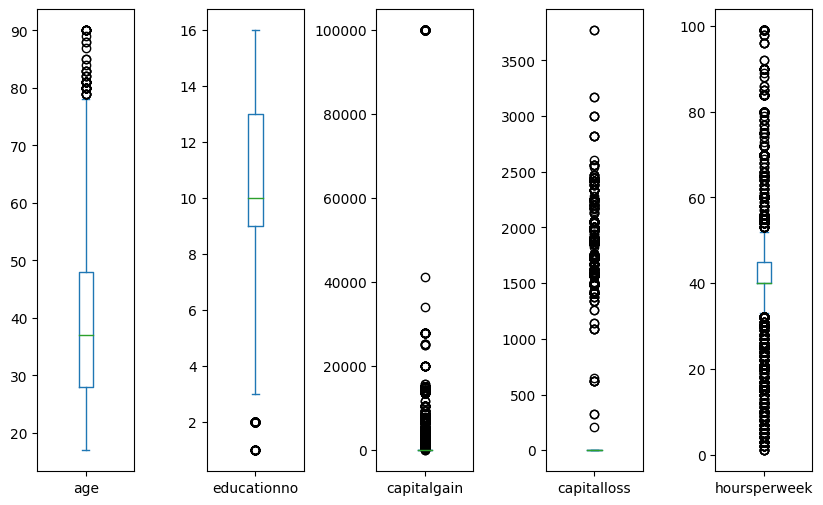

In [53]:
#Box plot visualization to view the outliers.
data.plot(kind = 'box', subplots = True, sharey = False, figsize = (10, 6))

plt.subplots_adjust(wspace = 0.75)
plt.show()

In [54]:
# Winsorization for "age" column
winsor = Winsorizer(capping_method = 'iqr', tail = 'both', fold = 1.5, variables = ['age'])

data['age'] = winsor.fit_transform(data[['age']])

In [55]:
# Winsorization for "educationno" column
winsor = Winsorizer(capping_method = 'iqr', tail = 'both', fold = 1.5, variables = ['educationno'])

data['educationno'] = winsor.fit_transform(data[['educationno']])

In [56]:
# Winsorization for "hoursperweek" column
winsor = Winsorizer(capping_method = 'iqr', tail = 'both', fold = 1.5, variables = ['hoursperweek'])

data['hoursperweek'] = winsor.fit_transform(data[['hoursperweek']])

In [57]:
X1 = data.iloc[:, :13]
Y1 = data.iloc[:, 13]

In [58]:
Y1

0         <=50K
1         <=50K
2          >50K
3          >50K
4         <=50K
          ...  
15055     <=50K
15056     <=50K
15057     <=50K
15058     <=50K
15059      >50K
Name: Salary, Length: 15060, dtype: object

In [59]:
model1 = pickle.load(open('svc_rcv.pkl', 'rb'))

In [60]:
## Scaling with MinMaxScaler
scale_pipeline = Pipeline([('scale', MinMaxScaler())])

scale_columntransfer = ColumnTransformer([('scale', scale_pipeline, numeric_features)]) # Skips the transformations for remaining columns

scale = scale_columntransfer.fit(X1)

In [61]:
scaled_data = pd.DataFrame(scale.transform(X1), columns = numeric_features)
scaled_data.describe()

,age,educationno,capitalgain,capitalloss,hoursperweek
count,15060.000000,15060.000000,15060.000000,15060.000000,15060.000000
mean,0.356535,0.547773,0.011203,0.023619,0.445687
std,0.218305,0.194861,0.077033,0.107767,0.307171
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.180328,0.461538,0.000000,0.000000,0.375000
50%,0.327869,0.538462,0.000000,0.000000,0.375000
75%,0.508197,0.769231,0.000000,0.000000,0.625000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
## Encoding
# Categorical features
encoding_pipeline = Pipeline([('onehot', OneHotEncoder())])

preprocess_pipeline = ColumnTransformer([('categorical', encoding_pipeline, categorical_features)])

clean =  preprocess_pipeline.fit(X1)

In [63]:
encode_data = pd.DataFrame(clean.transform(X1).todense())
encode_data

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15055,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15056,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15057,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15058,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [65]:
# To get feature names for Categorical columns after Onehotencoding 
encode_data.columns = clean.get_feature_names_out(input_features = X1.columns)
encode_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15060 entries, 0 to 15059
Data columns (total 97 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   categorical__workclass_ Federal-gov                15060 non-null  float64
 1   categorical__workclass_ Local-gov                  15060 non-null  float64
 2   categorical__workclass_ Private                    15060 non-null  float64
 3   categorical__workclass_ Self-emp-inc               15060 non-null  float64
 4   categorical__workclass_ Self-emp-not-inc           15060 non-null  float64
 5   categorical__workclass_ State-gov                  15060 non-null  float64
 6   categorical__workclass_ Without-pay                15060 non-null  float64
 7   categorical__education_ 10th                       15060 non-null  float64
 8   categorical__education_ 11th                       15060 non-null  float64
 9   catego

In [66]:
clean_data = pd.concat([scaled_data, encode_data], axis = 1) 
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15060 entries, 0 to 15059
Columns: 102 entries, age to categorical__native_ Yugoslavia
dtypes: float64(102)
memory usage: 11.7 MB


In [67]:
prediction = pd.DataFrame(model1.predict(clean_data), columns = ['Salary'])

In [68]:
prediction

,Salary
0,<=50K
1,<=50K
2,<=50K
3,>50K
4,<=50K
...,...
15055,<=50K
15056,<=50K
15057,>50K
15058,<=50K


In [69]:
np.mean(prediction['Salary'] == Y1)

0.84667994687915